<a href="https://colab.research.google.com/github/ShinyRyo/signate2business/blob/main/%E5%82%B5%E5%8B%99%E4%B8%8D%E5%B1%A5%E8%A1%8C/%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90(%E5%82%B5%E5%8B%99%E4%B8%8D%E5%B1%A5%E8%A1%8C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

#データの読み込み

In [2]:
base_dir = '/content/drive/MyDrive/0. Working/芳野さん/signate/債務不履行/data/'

In [3]:
import pandas as pd
train = pd.read_csv(base_dir + 'train.csv')
test = pd.read_csv(base_dir + 'test.csv')

#データ分析

##データの分類(量的変数:比例尺度・間隔尺度 と 質的変数：名義尺度・順序尺度)

In [4]:
train_df = train.copy()
test_df = test.copy()

In [5]:
train.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,88194295,1800.0,3 years,14.49,C4,NaN,debt_consolidation,665.0,Individual,FullyPaid
1,5146039,1200.0,5 years,16.29,C4,2 years,debt_consolidation,700.0,Individual,ChargedOff
2,3095896,2000.0,5 years,21.98,E4,10 years,home_improvement,670.0,Individual,FullyPaid
3,88625044,1000.0,3 years,8.59,A5,4 years,debt_consolidation,710.0,Individual,FullyPaid
4,1178189,1500.0,3 years,13.99,C1,4 years,debt_consolidation,680.0,Individual,FullyPaid


In [6]:
# 質的変数（カテゴリカル変数）と量的変数（数値型変数）の特定
category_vars = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
quantitative_vars = train_df.select_dtypes(include=[np.number]).columns.tolist()

In [7]:
# train_df にはあるが test_df にはない列を見つける
target_var = list(set(train_df.columns) - set(test_df.columns))[0]  # 目的変数の列名

In [8]:
# データの特性を解析して、4つの尺度（名義尺度、順序尺度、比例尺度、間隔尺度）に自動で分類する

# 各変数のデータタイプを確認
data_types = train_df.dtypes

# 名義尺度: カテゴリカルなデータタイプの変数
nominal_variables = data_types[data_types == 'object'].index.tolist()

# 数値データを持つ変数を一時的に比例尺度と間隔尺度の候補として扱う
numeric_variables = data_types[data_types != 'object'].index.tolist()

# 比例尺度と間隔尺度の候補から、さらに分析を行って分類
# ここでは、簡易的な方法として、一意の値の数を基に分類を試みる
# 通常、比例尺度はより多くの一意の値を持つ傾向がある
unique_value_counts = train_df[numeric_variables].apply(lambda x: x.nunique())

# 一意の値が少ない（例: 10未満）変数を間隔尺度と仮定
interval_variables = unique_value_counts[unique_value_counts < 10].index.tolist()

# 残りの数値変数を比例尺度とする
ratio_variables = list(set(numeric_variables) - set(interval_variables))

# 順序尺度: このデータセットには明確に順序尺度と識別できる変数はないため、手動で特定する必要がある
# 例えば、'grade'は順序がありそうだが、ここでは名義尺度として分類されているため、手動で変更することが可能
# ここでは自動化の範囲内で処理を行っているため、順序尺度の変数は空リストとする
ordinal_variables = []  # 手動で指定する必要がある変数

# 分類結果の確認
nominal_variables, ordinal_variables, ratio_variables, interval_variables


(['term',
  'grade',
  'employment_length',
  'purpose',
  'application_type',
  'loan_status'],
 [],
 ['interest_rate', 'id', 'credit_score', 'loan_amnt'],
 [])

In [9]:
len(train_df.columns)

10

##目的変数が質的データの場合

In [10]:
!pip install japanize-matplotlib -q
import japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


###説明変数が質的変数の場合

####名義尺度と名義尺度の場合

In [11]:
nominal_variables

['term',
 'grade',
 'employment_length',
 'purpose',
 'application_type',
 'loan_status']

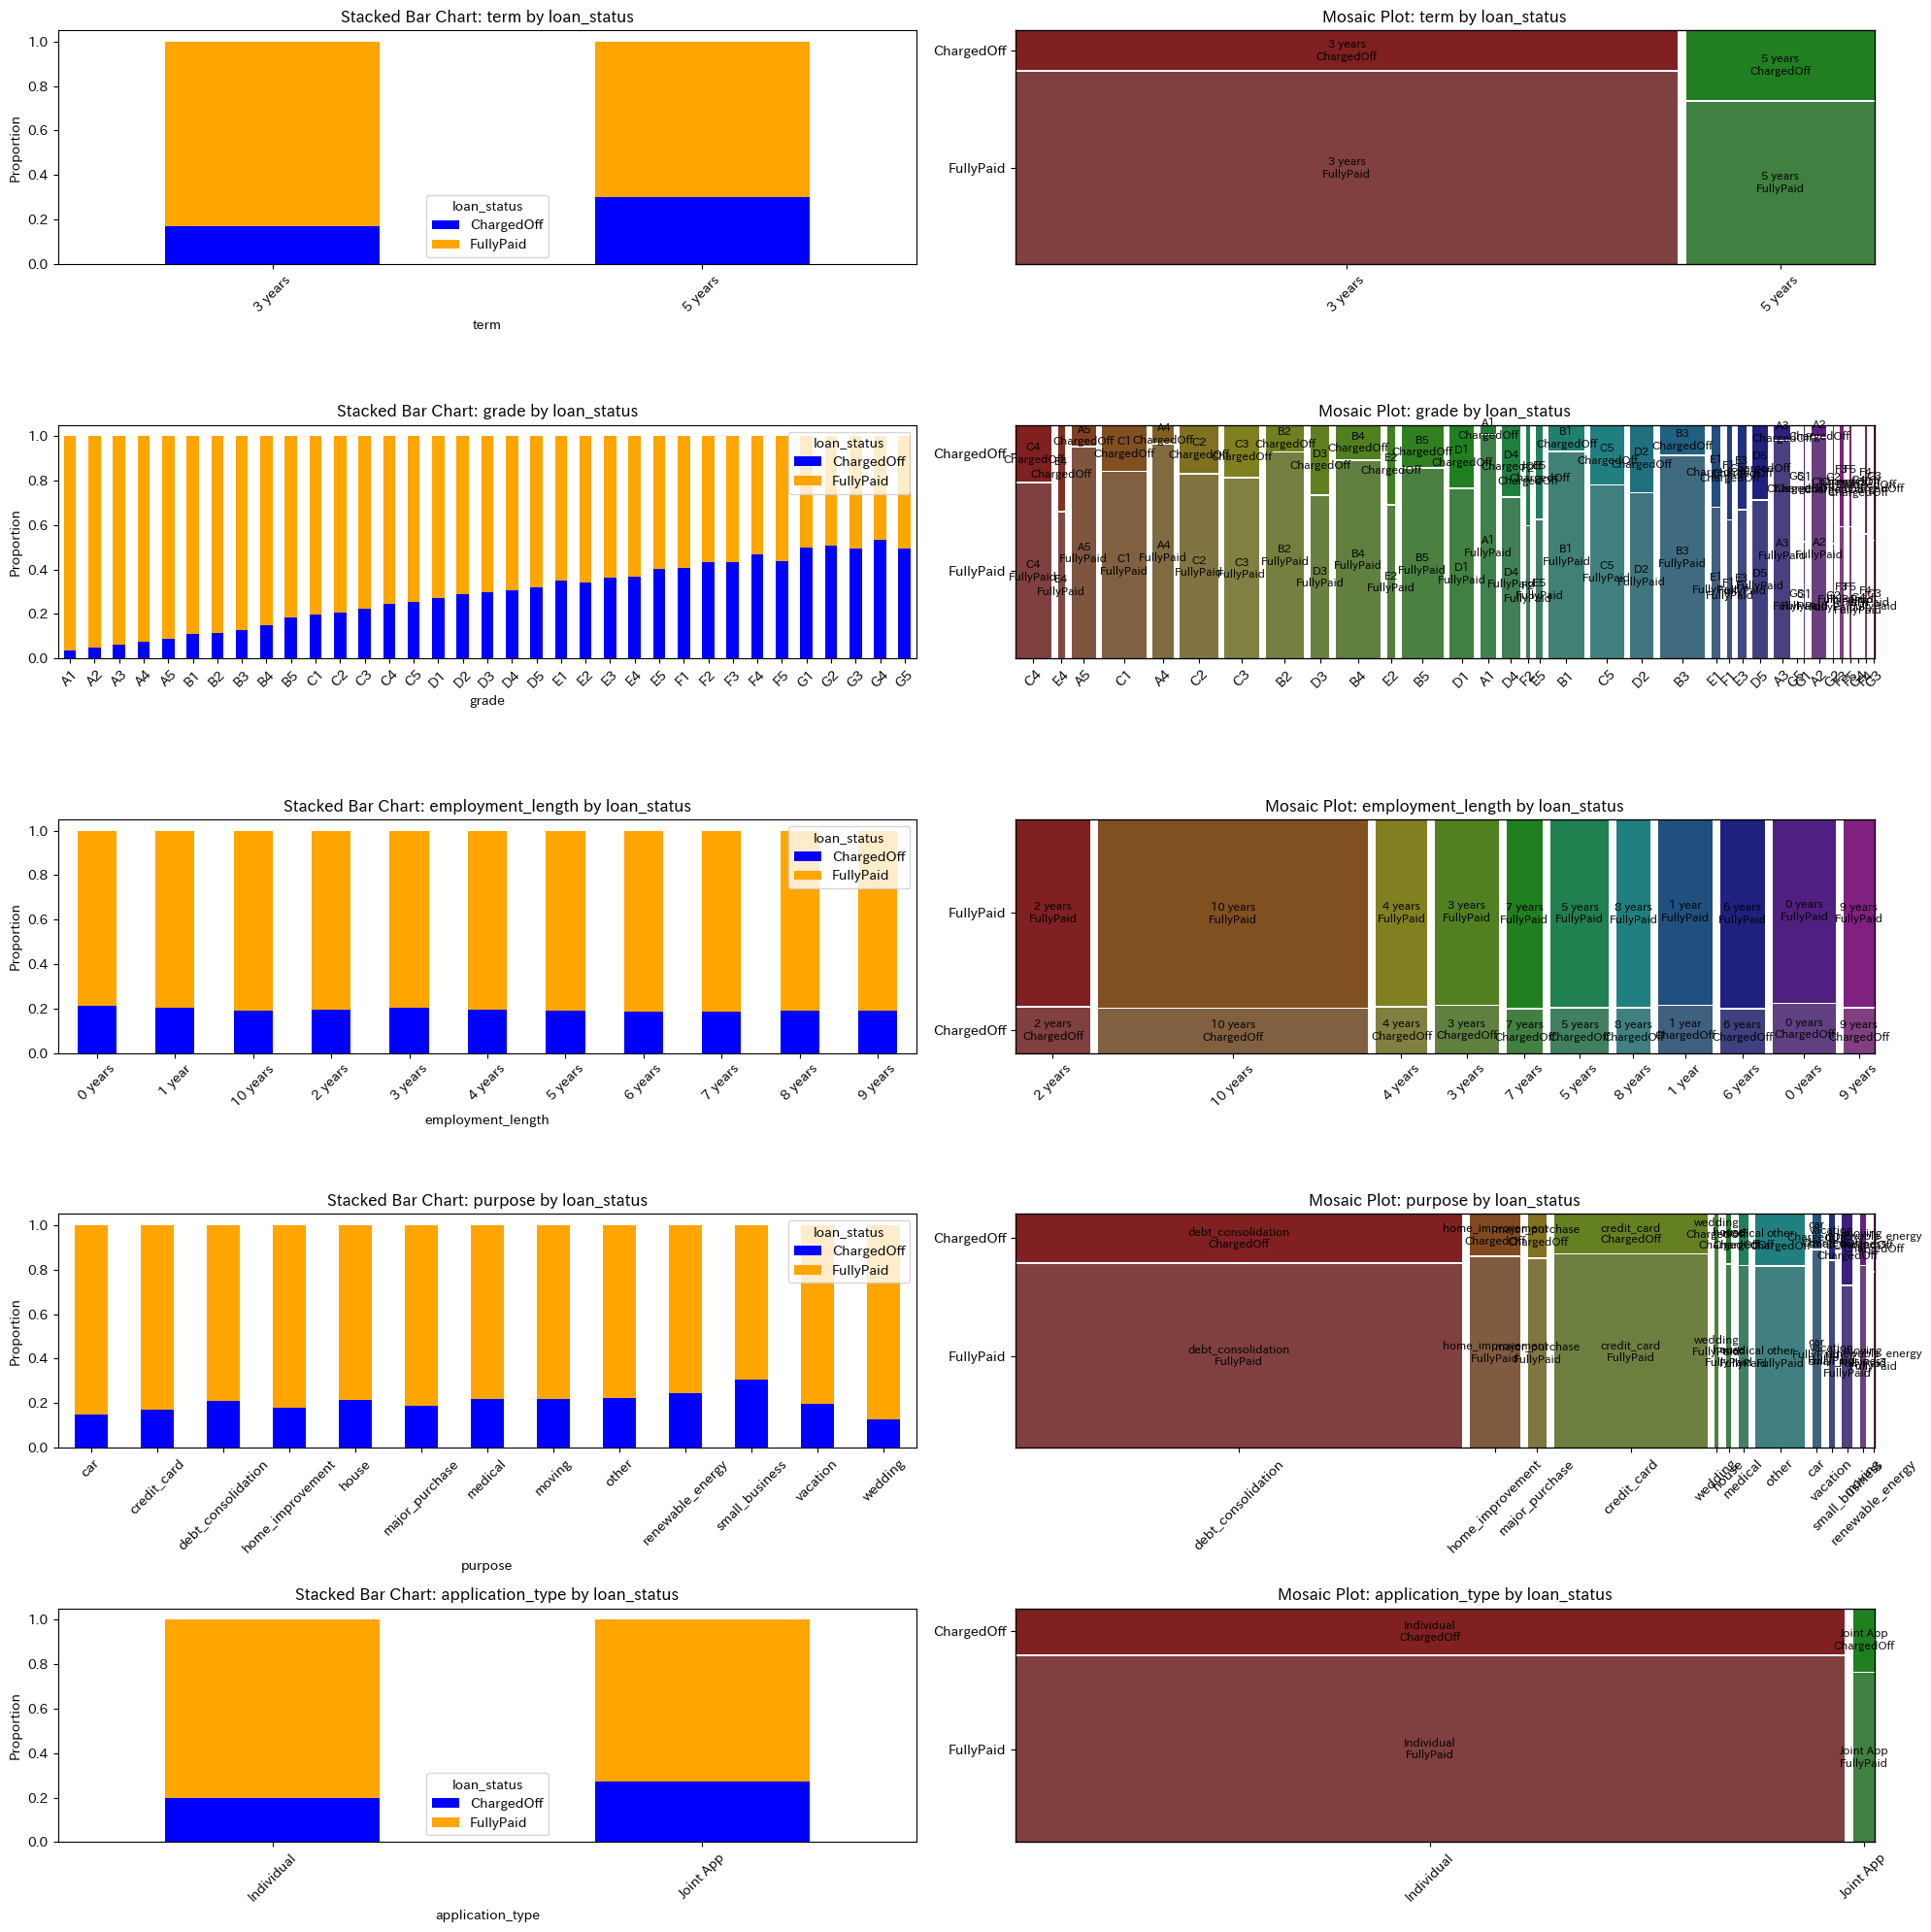

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

# Define the categorical variables and the target variable
category_vars = ['term', 'grade', 'employment_length', 'purpose', 'application_type',]  # Replace with your actual category variables
target_var = 'loan_status'

# Calculate the number of rows needed for the subplots
n_cols = 2
# カテゴリ変数の数に基づいて必要な行数を計算します（各変数に対して2つのプロットを作成するため、2倍します）
n_rows = int(np.ceil(len(category_vars) * 2 / n_cols))

# サブプロットを作成
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

# Flatten the axes array for easy indexing
axes_list = axes.flatten()

# Iterate over the category variables to create mosaic plots and stacked bar charts
for i, category_var in enumerate(category_vars):
    # Create a cross-tabulation for the stacked bar chart
    cross_tab = pd.crosstab(train_df[category_var], train_df[target_var], normalize='index')

    # Stacked bar chart
    cross_tab.plot(kind='bar', stacked=True, ax=axes_list[i*2], color=['blue', 'orange'])
    axes_list[i*2].set_title(f'Stacked Bar Chart: {category_var} by {target_var}')
    axes_list[i*2].set_xlabel(category_var)
    axes_list[i*2].set_ylabel('Proportion')
    axes_list[i*2].tick_params(axis='x', rotation=45)

    # Mosaic plot
    mosaic(train_df, [category_var, target_var], ax=axes_list[i*2 + 1], gap=0.01)
    axes_list[i*2 + 1].set_title(f'Mosaic Plot: {category_var} by {target_var}')
    axes_list[i*2 + 1].set_xlabel('')
    axes_list[i*2 + 1].set_ylabel('')
    axes_list[i*2 + 1].tick_params(axis='x', rotation=45)

# Remove any extra axes not being used
for j in range(len(category_vars) * 2, len(axes_list)):
    fig.delaxes(axes_list[j])

# Adjust the layout
plt.tight_layout()
plt.show()


####名義尺度と間隔尺度の場合

###説明変数が量的変数の場合

####名義尺度と比例尺度の場合

####名義尺度と間隔尺度の場合

In [13]:
ratio_variables

['interest_rate', 'id', 'credit_score', 'loan_amnt']

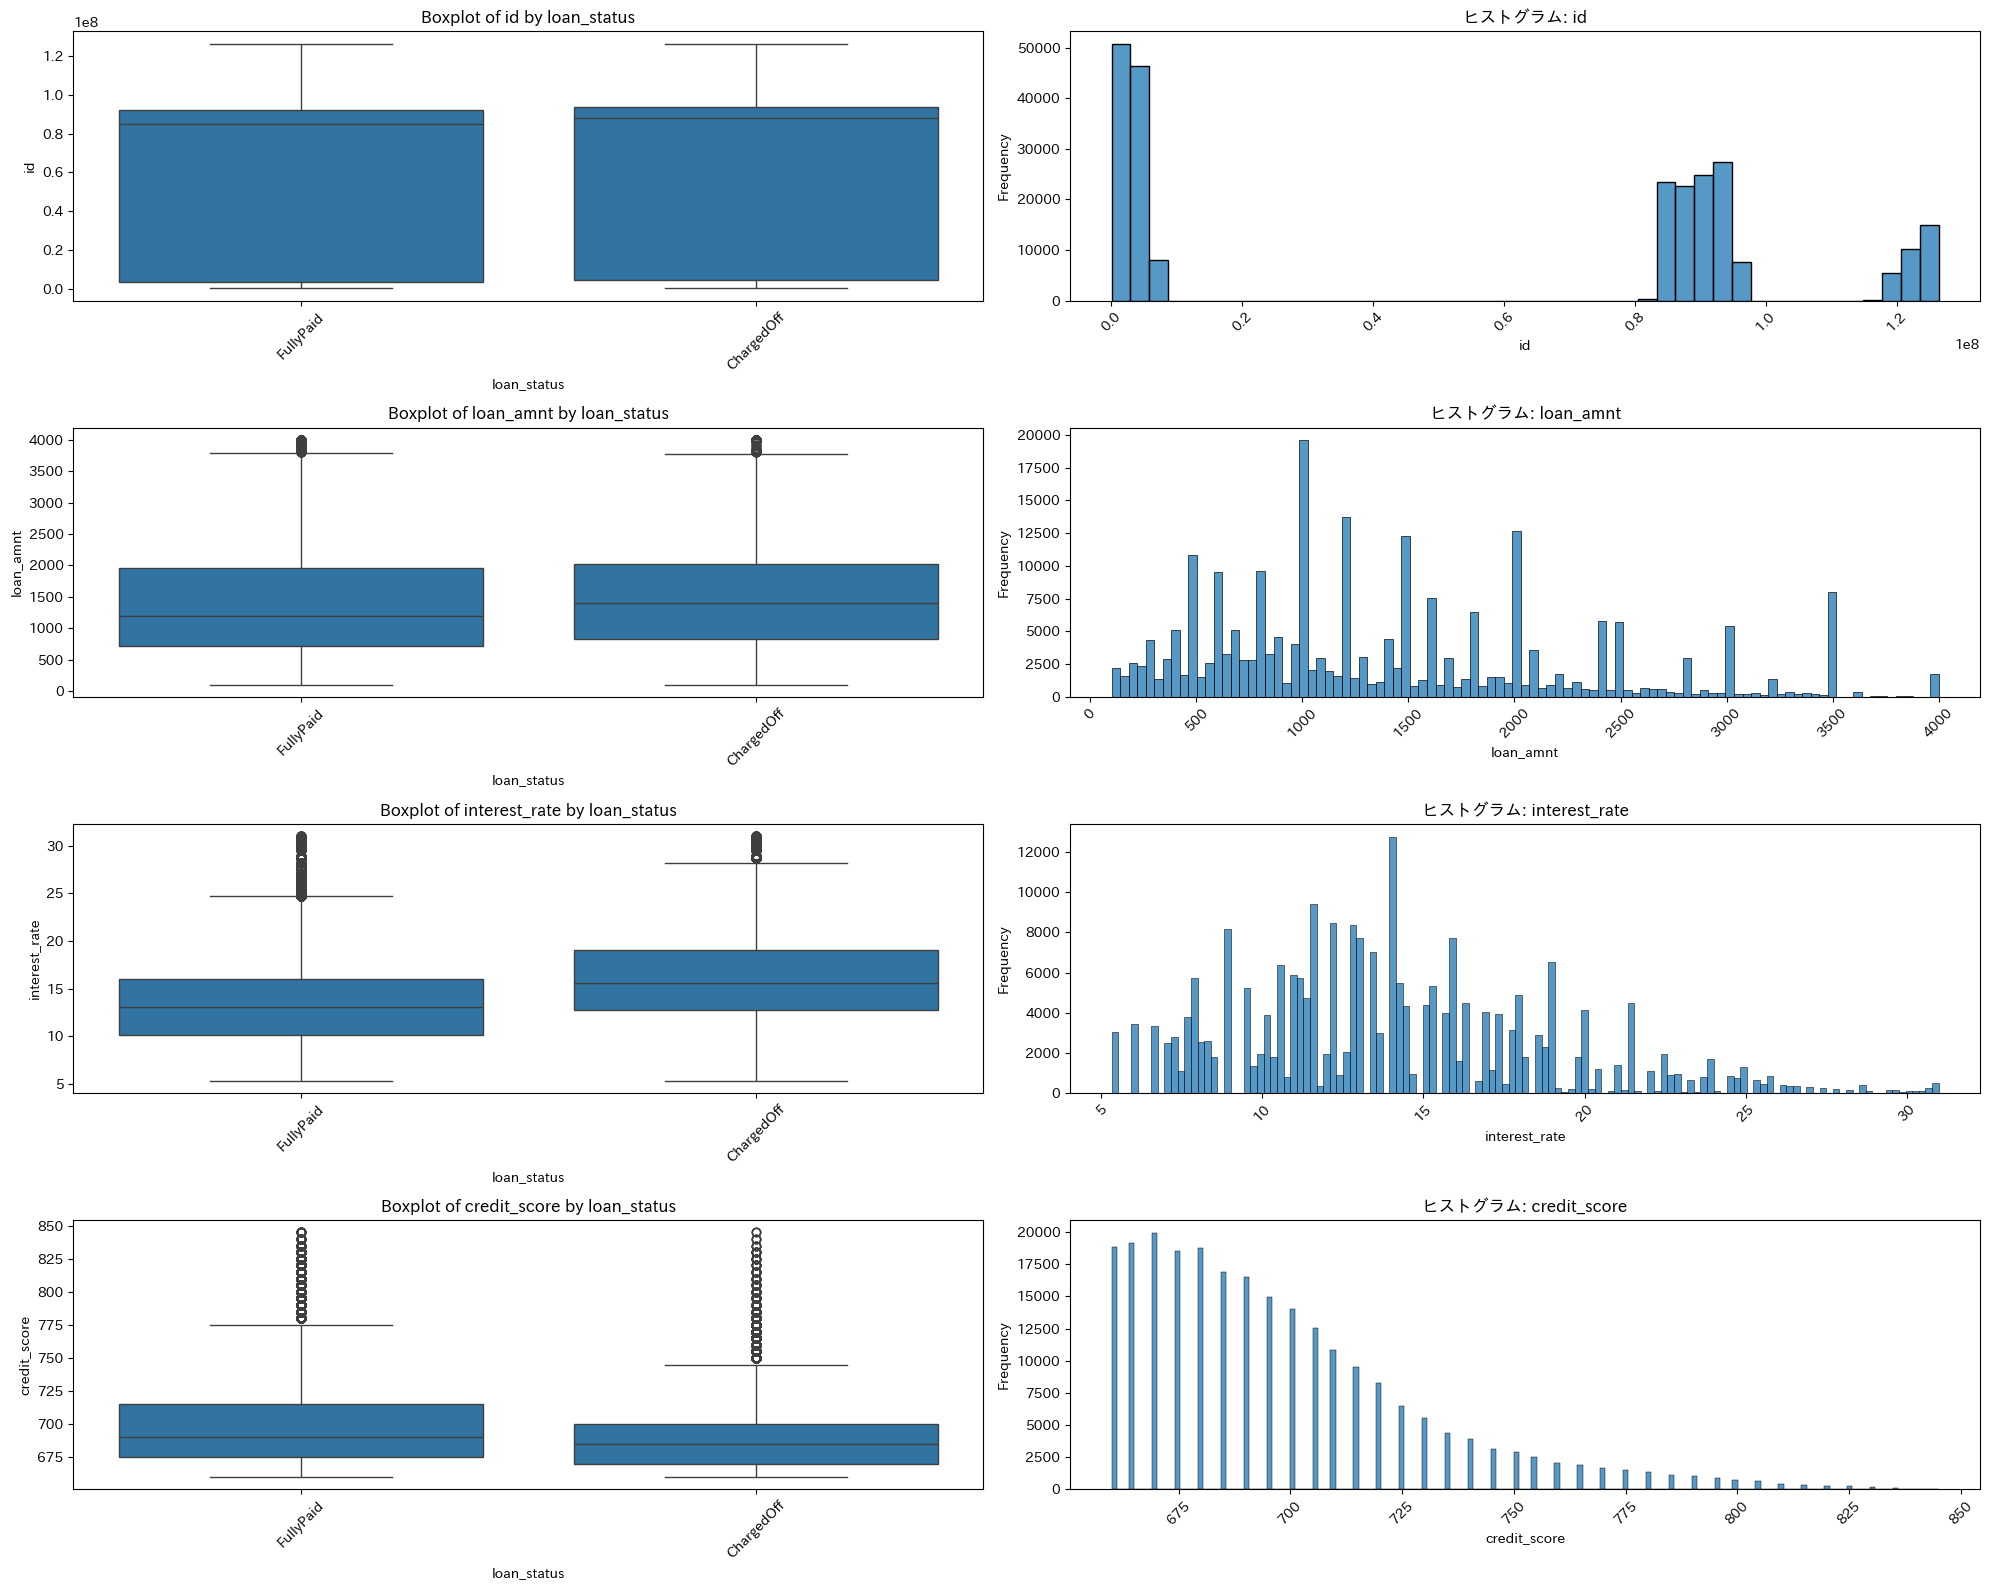

In [14]:
# 量的変数のプロット用の設定
n_cols_quant = 2  # 箱ひげ図とヒストグラムのための列数
n_rows_quant = len(quantitative_vars)  # 量的変数の数に基づいて行数を計算

# 量的変数のためのサブプロットを生成
fig_quant, axes_quant = plt.subplots(n_rows_quant, n_cols_quant, figsize=(20, n_rows_quant * 4))
axes_quant_list = axes_quant.flatten()

# 量的変数ごとに箱ひげ図とヒストグラムをプロット
for i, quant_var in enumerate(quantitative_vars):
    # 箱ひげ図
    sns.boxplot(x=target_var, y=quant_var, data=train_df, ax=axes_quant_list[i*2])
    axes_quant_list[i*2].set_title(f'Boxplot of {quant_var} by {target_var}')
    axes_quant_list[i*2].set_xlabel(target_var)
    axes_quant_list[i*2].set_ylabel(quant_var)
    axes_quant_list[i*2].tick_params(axis='x', rotation=45)

    # ヒストグラムのためのビン数の計算
    Q1 = train_df[quant_var].quantile(0.25)
    Q3 = train_df[quant_var].quantile(0.75)
    IQR = Q3 - Q1
    N = len(train_df)
    bin_width = 2 * IQR * (N ** (-1/3))
    bin_num = int((train_df[quant_var].max() - train_df[quant_var].min()) / bin_width)

    # ヒストグラム
    sns.histplot(train_df[quant_var], bins=bin_num, ax=axes_quant_list[i*2 + 1])
    axes_quant_list[i*2 + 1].set_title(f'ヒストグラム: {quant_var}')
    axes_quant_list[i*2 + 1].set_xlabel(quant_var)
    axes_quant_list[i*2 + 1].set_ylabel('Frequency')
    axes_quant_list[i*2 + 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


##特殊なケース:地理情報（緯度・経度）

##その他の分析

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def perform_initial_analysis_quantitative_target(df, category_vars, quantitative_vars, target_var):
    """
    指定されたデータフレームに対し、目的変数が量的データである場合の
    カテゴリカル変数の箱ひげ図と量的変数の散布図を描画する汎用関数。

    Parameters:
    - df: DataFrame, 分析対象のデータフレーム
    - category_vars: list, 可視化したいカテゴリカル変数のリスト
    - quantitative_vars: list, 可視化したい量的変数のリスト
    - target_var: str, 目的変数（量的変数）
    """
    # カテゴリカル変数の箱ひげ図
    for category_var in category_vars:
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=category_var, y=target_var, data=df)
        plt.title(f'Boxplot of {target_var} by {category_var}')
        plt.xlabel(category_var)
        plt.ylabel(target_var)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 量的変数の散布図
    for quant_var in quantitative_vars:
        if quant_var != target_var:  # 目的変数自体とのプロットは除外
            plt.figure(figsize=(8, 4))
            sns.scatterplot(x=quant_var, y=target_var, data=df)
            plt.title(f'Scatter plot of {target_var} vs {quant_var}')
            plt.xlabel(quant_var)
            plt.ylabel(target_var)
            plt.tight_layout()
            plt.show()

In [16]:
category_var = 'city'

In [17]:
# 注目すべきカテゴリカルデータをリストに入れる
focus_categorical_vars = ['city', 'room_type', 'bed_type', 'cancellation_policy', 'property_type']

# リストの内容を表示（確認用）
print(focus_categorical_vars)

['city', 'room_type', 'bed_type', 'cancellation_policy', 'property_type']


In [18]:
perform_initial_analysis_quantitative_target(train_df, focus_categorical_vars, quantitative_vars, target_var)

ValueError: Could not interpret value `city` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x400 with 0 Axes>

In [ ]:
train_df.head()

In [ ]:
train_df['review_scores_rating'].value_counts()

In [ ]:
# review_scores_rating の値を10点刻みで分類
train_df['review_scores_rating_group'] = pd.cut(train_df['review_scores_rating'], bins=range(0, 110, 10), right=False)

# 新しい分類の値の数をカウント
review_scores_rating_group_counts = train_df['review_scores_rating_group'].value_counts().sort_index()

review_scores_rating_group_counts

In [ ]:
# review_scores_rating_groupの範囲ごとに価格の中央値と平均値を計算
price_stats_by_review_score_group = train_df.groupby('review_scores_rating_group')['y'].agg(['median', 'mean'])

price_stats_by_review_score_group

In [ ]:
price_stats_by_review_score_group

In [ ]:
price_stats_by_review_score_group['median']

In [ ]:
!pip install japanize-matplotlib -q
import japanize_matplotlib

In [ ]:
import matplotlib.pyplot as plt

# 中央値と平均値をプロットするためのデータ準備
medians = price_stats_by_review_score_group['median']
means = price_stats_by_review_score_group['mean']
index = range(len(price_stats_by_review_score_group))

# 棒グラフの作成
plt.figure(figsize=(10, 4))
plt.bar(index, medians, width=0.4, label='Median Price', align='center')
plt.bar(index, means, width=0.4, label='Mean Price', align='edge')

# 軸ラベルと凡例の追加
plt.xlabel('Review Score Range')
plt.ylabel('Price')
plt.title('Price by Review Score Range')
plt.xticks(index, price_stats_by_review_score_group.index, rotation=45)
plt.legend()

# グラフの表示
plt.tight_layout()
plt.show()


In [ ]:
# 数量変数リスト
quantitative_vars = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
# 箱ひげ図を描画
plt.figure(figsize=(20, 10))
for i, var in enumerate(quantitative_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=var, y='y', data=train_df)
    plt.title(f'Boxplot of price by {var}')
    plt.xlabel(var)
    plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [ ]:
# データの再読み込み
#train_df_new = pd.read_csv('/mnt/data/train (5).csv')

# 緯度と経度のデータでKMeansクラスタリング
kmeans = KMeans(n_clusters=5, random_state=0)
train_df['cluster'] = kmeans.fit_predict(train_df[['latitude', 'longitude']])

# クラスターごとの価格の中央値と平均値を計算
cluster_price_stats = train_df.groupby('cluster')['y'].agg(['median', 'mean']).reset_index()

cluster_price_stats

#施策の生成

##Geminiによる分析と施策の提案

##1. ローン期間の最適化
具体例: 短期ローンの奨励

理由: 積み上げ棒グラフから、短期ローン（例：3年）の完済率が高いことが示唆されている場合、短期ローンを奨励することで全体のデフォルト率を低下させることができます。

施策内容: 利息率の割引や手数料の免除などのインセンティブを短期ローンに提供する。また、短期ローンを選択した顧客に対して、返済スケジュールの柔軟性を提供するなどのサービスを実施します。


##2. クレジットスコアを基にしたリスク調整
具体例: クレジットスコアベースの利息割引

理由: 箱ひげ図から、高いクレジットスコアを持つ顧客のデフォルト率が低いことが示されている場合、クレジットスコアをリスク評価により強く反映させることが可能です。

施策内容: クレジットスコアが一定基準を超える顧客に対して、利息率の割引を提供します。これにより、信用力の高い顧客のロイヤルティを高め、リスクの低いローンポートフォリオを構築します。

#欠損値の補完

モデルを14の変数で構築する際に、シナリオで提供されていないデータがある場合、以下のような扱いが考えられます：

1. 欠損値の補完: 特定の変数のデータが欠けている場合、統計的手法（平均値、中央値、最頻値補完）や予測モデリングを用いてその値を推定することができます。

1. 既知のデフォルト値の使用: 特定の変数について、普遍的または一般的に受け入れられているデフォルト値を使用することができます（例：アメニティが明記されていない場合、基本的なアメニティセットを仮定する）。

1. ゼロまたはカテゴリ的欠損のマーキング: 何も情報が提供されていない変数は、ゼロや特定のカテゴリ（例えば「不明」や「該当なし」）でマークすることができます。

1. 専門家の意見やドメイン知識の活用: 欠損データが重要な変数である場合は、専門家の意見やドメイン知識を用いて合理的な値を割り当てることができます。

1. モデルによる推測: 他の変数からの情報を活用して、欠損しているデータの予測値をモデルによって推測することができます。

1. 欠損データパターンの分析: 欠損データがランダムでない場合（例えば特定のカテゴリで高い欠損率が見られるなど）、そのパターンを分析し、欠損が価格に影響を与える可能性があるかどうかを判断します。

1. 欠損値を含む行の削除: 分析の目的によっては、欠損値を含む行をデータセットから除外することが適切な場合もありますが、これによって情報が失われる可能性があるため注意が必要です。

#ロジックの生成

##短期ローン優遇ロジック

簡単のため該当するカテゴリに対して5%の金利の優遇を適応します。

In [ ]:
def loan_term_discount(df, term_threshold='3 years', term_discount=0.005):
    # 条件に基づいて割引率を適用
    df['discounted_rate'] = df.apply(
        lambda row: term_discount if row['term'] == term_threshold else row['discounted_rate'],
        axis=1
    )

    return df

##優良クレジットスコア優遇ロジック

簡単のため閾値以上の数値を有する人に対して5%の金利の優遇を適応します。

In [ ]:
def credit_score_discount(df, credit_score_discount=0.005):
    credit_score_mean = df['credit_score'].mean()

    df['discounted_rate'] = df.apply(
        lambda row: row['discounted_rate'] + credit_score_discount if row['credit_score'] >= credit_score_mean else row['discounted_rate'],
        axis=1
    )

    return df

##ロジックの適応

discounted_rateカラムを作成して誰がどの程度の金利の優遇があるかを算出します。

In [ ]:
train_df = train.copy()

In [ ]:
train_df['discounted_rate'] = 0

In [ ]:
train_df.head()

In [ ]:
discounted_train_df = loan_term_discount(train_df)
discounted_train_df

In [ ]:
discounted_train_df = credit_score_discount(discounted_train_df)
discounted_train_df

#シナリオデータの生成

discounted_rateカラムに累積したスコアを適応します。

In [ ]:
train4sim = train.copy()

In [ ]:
train4sim['interest_rate'] = train4sim['interest_rate'] - discounted_train_df['discounted_rate']
train4sim

#シミュレーション

In [ ]:
import lightgbm as lgb

# 保存されたモデルを読み込む
loaded_model = lgb.Booster(model_file='model.txt')

##モデルの確認

In [ ]:
train4pred = train.copy()
test4pred = test.copy()

In [ ]:
!pip install pycaret -q

In [ ]:
# PyCaretの設定と初期化
from pycaret.regression import setup, compare_models, tune_model, finalize_model, predict_model

# setup関数を用いて環境を初期化します。この段階でデータ型の指定や欠損値の扱い、
# 特徴量の生成などのデータ前処理が行われます。
# session_idは再現性を保つためのランダムシードです。
regression_setup = setup(data=train4pred, target='y', session_id=123)

# モデルの比較
# compare_models関数を使って異なるモデルを比較し、ベンチマークします。
best_model = compare_models()

# モデルのチューニング
# tune_model関数でモデルのハイパーパラメータをチューニングします。
tuned_model = tune_model(best_model)

# モデルの最終化
# finalize_model関数でチューニングされたモデルを最終化し、
# トレーニングセット全体で再度訓練します。
final_model = finalize_model(tuned_model)

# 予測
# predict_model関数でテストデータセットを使って予測を行います。
predictions = predict_model(final_model, data=test4pred)


In [ ]:
predictions

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
target_columns = list(set(train4pred.columns) - set(test4pred.columns))[0]
categorical_cols = train4pred.select_dtypes(include=['object', 'category']).columns.drop(target_columns, errors='ignore').tolist()
numerical_cols = train4pred.select_dtypes(include=[np.number]).columns.drop(target_columns, errors='ignore').tolist()

le_exps = {}
# カテゴリカルデータをラベルエンコーディング
for col in categorical_cols:
    le = LabelEncoder()
    all_data = pd.concat([train4pred[col], train4pred[col]], axis=0).astype(str)
    le.fit(all_data)
    train4pred[col] = le.transform(train4pred[col].astype(str))
    test4pred[col] = le.transform(test4pred[col].astype(str))
    le_exps[col] = le

# 目的変数をエンコード
le_target = LabelEncoder()
train4pred[target_columns] = le_target.fit_transform(train4pred[target_columns])

# 目的変数と特徴量を分割
X_train = train4pred.drop(columns=[target_columns])
y_train = train4pred[target_columns]

In [ ]:
le_exps

In [ ]:
# LightGBMのデータセット形式に変換
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_cols, free_raw_data=False)

In [ ]:
loaded_model.predict(X_train)

In [ ]:
train4sim.head()

##シナリオデータの確認

In [ ]:
train4sim = train.copy()
test4sim = test.copy()

In [ ]:
le_exps

In [ ]:
# le_expsを使う
# カテゴリカルデータをラベルエンコーディング
for col in categorical_cols:
    le = le_exps[col]
    train4sim[col] = le.transform(train4sim[col].astype(str))

In [ ]:
train4sim.head()

##シミュレーション前

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# loan_statusの値のカウントを計算
loan_status_counts = train['loan_status'].value_counts()

# 棒グラフで可視化
plt.figure(figsize=(8, 3))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values)
plt.title('Loan Status Frequency')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # X軸のラベルが重ならないように回転
plt.show()

##シミュレーション後

In [ ]:
simX = train4sim.drop(columns=['loan_status'])
simy = train4sim['loan_status']

In [ ]:
# 元のモデルを使用して予測を行う
y_pred_simulated = loaded_model.predict(simX, num_iteration=loaded_model.best_iteration)

# 予測結果を0または1に丸める
y_pred_simulated_rounded = np.round(y_pred_simulated)

In [ ]:
# LabelEncoderインスタンス（loan_statusのエンコーディングに使用）
# このlabel_encoderは、以前にloan_statusをエンコードするためにfitされたものです
# label_encoder = encoders[target_column]

# エンコードされた予測結果をデコード
y_pred_simulated_decoded = le_target.inverse_transform(y_pred_simulated_rounded.astype(int))

# デコードされた値のカウントを計算
unique, counts = np.unique(y_pred_simulated_decoded, return_counts=True)

# 棒グラフで可視化
plt.figure(figsize=(8, 3))
sns.barplot(x=unique, y=counts)
plt.title('Simulated Loan Status Frequency')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # X軸のラベルが重ならないように回転
plt.show()